In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import paderbox as pb

In [4]:
from collections import defaultdict
import itertools
def plot_meeting(ex):
    with pb.visualization.axes_context(columns=1, figure_size=(10, 3)) as ac:
        activity = defaultdict(pb.array.interval.zeros)
        speech_activity = defaultdict(pb.array.interval.zeros)
        num_samples = pb.utils.nested.get_by_path(ex, 'num_samples.original_source', allow_early_stopping=True)
        for o, l, s,  in zip(ex['offset']['original_source'], num_samples, ex['speaker_id']):
            speech_activity[s][o:o+l]=True

        pb.visualization.plot.activity(speech_activity, ax=ac.new)
        
def plot_meetings(generator_dataset, number=6, columns=3, figure_width=10):
    with pb.visualization.axes_context(columns=columns, figure_size=(figure_width, 3)) as ac:
        for ex in itertools.islice(generator_dataset, number):
            activity = defaultdict(pb.array.interval.zeros)
            num_samples = pb.utils.nested.get_by_path(ex, 'num_samples.original_source', allow_early_stopping=True)
            for o, l, s in zip(ex['offset']['original_source'], num_samples, ex['speaker_id']):
                activity[s][o:o+l] = True

            pb.visualization.plot.activity(activity, ax=ac.new)

def load_audio(example):
    example['audio_data'] = pb.io.audioread.recursive_load_audio(example['audio_path'])
    return example

In [5]:
%load_ext autoreload
%autoreload 2
from padercontrib.database.sms_librispeech_meeting import mixture_generator as g

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparation: The input dataset
The mixture/meeting generators are generic, i.e., they work with any database that contains examples of single-speaker speech.
The input database has to have its examples in the correct format, i.e., they have to contain the correct keys.

The examples have to have the following format:
 - `example_id` (`str`): The ID of the input example. Has to be unique in the input dataset
 - `num_samples` or `num_samples.observation` (`int`): The number of samples in the example
 - `speaker_id` (`str`): The ID of the speaker that uttered the speech in this example
 - `audio_path` or `audio_path.observation` (`str`): The path to the audio, will later be in `audio_path.original_source`
 
For meeting data additionally:
 - `scenario` (`str`): An identifier that uniquely identifies a "scenario" that should not change for a single speaker in a meeting. E.g., in LibriSpeech the scenario should be `f"{chapter_id}_{speaker_id}"`. Defaults to `speaker_id`.

All other keys are simply copied over from the input examples, so all information present in the input examples will be present in the generated mixtures.

In [6]:
# Prepare input datasets
from padercontrib.database.wsj import WSJ_8kHz
input_ds = WSJ_8kHz().get_dataset('test_eval92')
input_ds[0]

{'audio_path': {'observation': '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c0401.wav'},
 'example_id': '440c0401',
 'gender': 'male',
 'kaldi_transcription': 'DRAVO LAST MONTH AGREED IN PRINCIPLE TO SELL ITS INLAND WATER TRANSPORTATION STEVEDORING AND PIPE FABRICATION BUSINESSES FOR AN UNDISCLOSED SUM',
 'num_samples': {'observation': 90968},
 'speaker_id': '440',
 'transcription': 'DRAVO LAST MONTH AGREED IN PRINCIPLE TO SELL ITS INLAND WATER TRANSPORTATION STEVEDORING AND PIPE FABRICATION BUSINESSES FOR AN UNDISCLOSED SUM',
 'dataset': 'test_eval92'}

## Fully overlapped mixtures

### Like WSJ0-2mix

In [7]:
# Deterministic, anechoic, no offset, like WSJ0-2mix

# Compute a composition of base examples. This makes sure that the speaker distribution
# in the mixtures is equal to the speaker distribution in the original database.
ds = g.get_composition_dataset(input_dataset=input_ds, num_speakers=2)

# If required: Offset the utterances
ds = ds.map(g.ConstantOffsetSampler(0))

# If required: Add log_weights to simulate volume differences
ds = ds.map(g.UniformLogWeightSampler(max_weight=5))

len(ds), ds[0]

(333,
 {'audio_path': {'original_source': ['/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040d.wav',
    '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040i.wav']},
  'example_id': '0_440c040d_447c040i',
  'gender': ['male', 'male'],
  'kaldi_transcription': ['AFTER THE CLOSE OF TRADING THE FORECASTS WERE INCREASED',
   "NAKASONE SELECTED NOBORU TAKESHITA TO SUCCEED HIM AS JAPAN'S PREMIER"],
  'num_samples': {'original_source': [47097, 55180], 'observation': 55180},
  'speaker_id': ['440', '447'],
  'transcription': ['AFTER THE CLOSE OF TRADING THE FORECASTS WERE INCREASED',
   "NAKASONE SELECTED NOBORU TAKESHITA TO SUCCEED HIM AS JAPAN'S PREMIER"],
  'dataset': 'test_eval92',
  'scenario': ['440', '447'],
  'num_speakers': 2,
  'source_dataset': ['test_eval92', 'test_eval92'],
  'source_id': ['440c040d', '447c040i'],
  'offset': {'original_source': [0, 0]},
  'log_weights': [0.5279534137380733, -0.5279534137380728]})

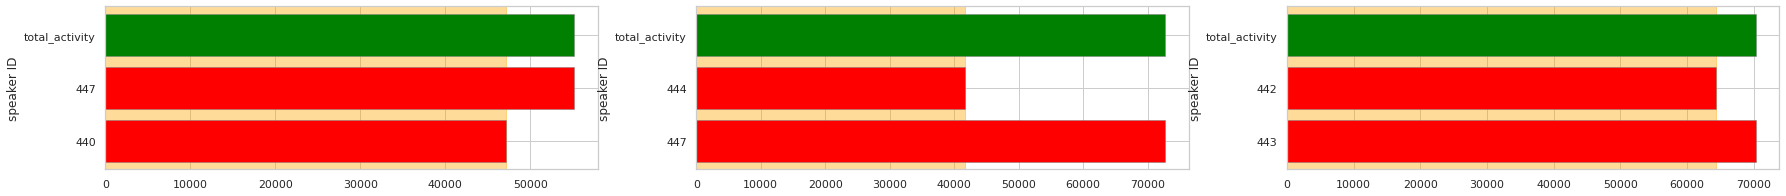

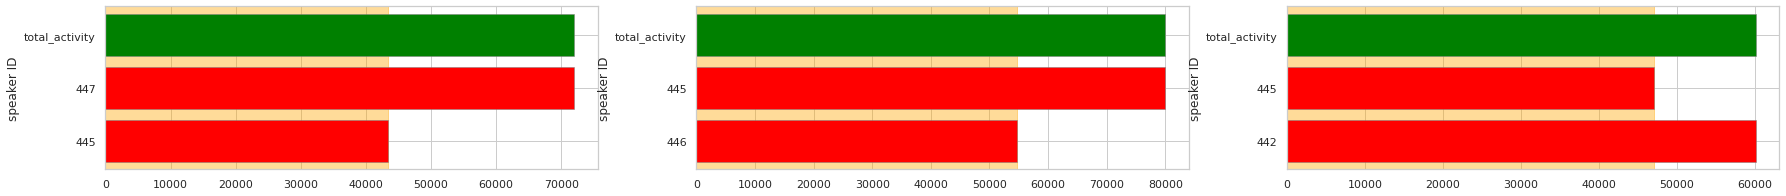

In [8]:
plot_meetings(ds)

### Like SMS-WSJ

In [9]:
ds = g.get_composition_dataset(input_dataset=input_ds, num_speakers=2)
ds = ds.map(g.SMSWSJOffsetSampler())
ds = ds.map(g.UniformLogWeightSampler(max_weight=5))
ds = ds.map(g.RIRSampler.from_scenarios_json('/net/db/sms_wsj/rirs/scenarios.json', 'test_eval92'))
ds[0]

{'audio_path': {'original_source': ['/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040d.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040i.wav'],
  'rir': [PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_0.wav'),
   PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_1.wav')]},
 'example_id': '0_440c040d_447c040i',
 'gender': ['male', 'male'],
 'kaldi_transcription': ['AFTER THE CLOSE OF TRADING THE FORECASTS WERE INCREASED',
  "NAKASONE SELECTED NOBORU TAKESHITA TO SUCCEED HIM AS JAPAN'S PREMIER"],
 'num_samples': {'original_source': [47097, 55180], 'observation': 55180},
 'speaker_id': ['440', '447'],
 'transcription': ['AFTER THE CLOSE OF TRADING THE FORECASTS WERE INCREASED',
  "NAKASONE SELECTED NOBORU TAKESHITA TO SUCCEED HIM AS JAPAN'S PREMIER"],
 'dataset': 'test_eval92',
 'scenario': ['440', '447'],
 'num_speakers': 2,
 'source_dataset': ['test_eval92', 'test_eval92'],
 'source_id': ['440c040d', '447c040i'],
 'offset': {'original_source': [7766, 0]},
 'log_weights'

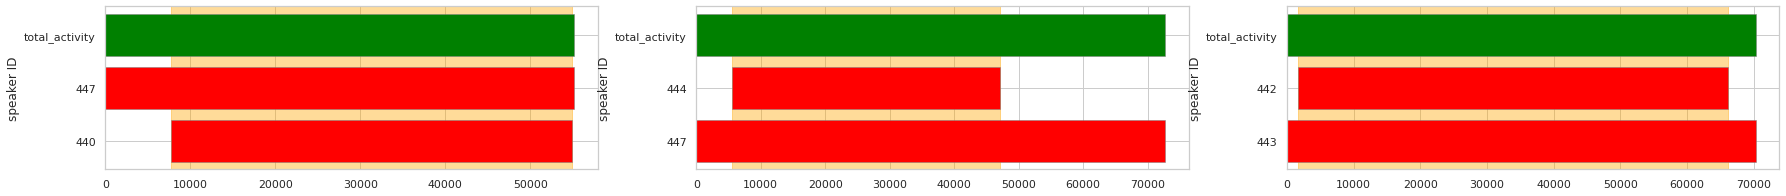

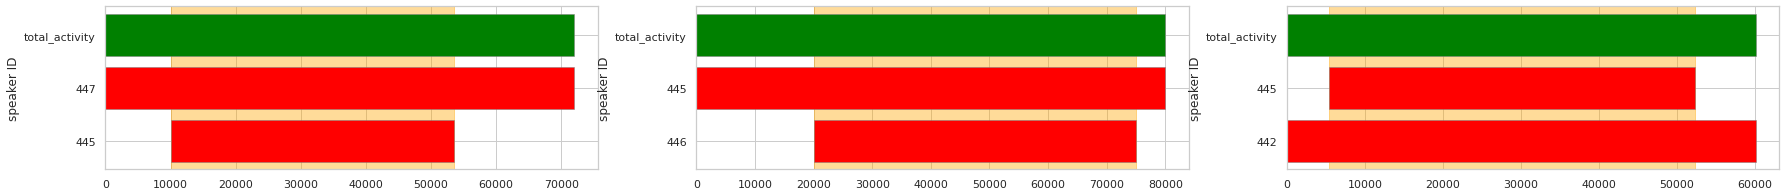

In [10]:
plot_meetings(ds)

In [11]:
# Load an example
from padercontrib.database.sms_librispeech_meeting.scenario import multi_channel_scenario_map_fn
ds = ds.map(load_audio).map(multi_channel_scenario_map_fn)
ex = ds[0]
pb.io.play(ex['audio_data']['observation'], sample_rate=8000)

/home/thequilo/workspace/python/paderbox/paderbox/io/audioread.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_data = np.array(data)


### Dynamic Mixing

In [12]:
# Dynamic mixing: Set the rng argument to `True` to get a non-deterministic dataset that changes its contents 
# every time it is iterated. Useful if you want to train on an infinite stream of randomly generated examples
# TODO: dynamic_ -> rng
ds = g.get_composition_dataset(input_dataset=input_ds, num_speakers=2, rng=True)
# only the function above this line changed from the determinstic case
# -------------------------------------------------------------------------------------------------------------------
# the part below this line is deterministic and equal to the cell above
ds = ds.map(g.SMSWSJOffsetSampler())
ds = ds.map(g.UniformLogWeightSampler(max_weight=5))

In [13]:
# Check that iterating two times gives different examples
for _ in range(2):
    for e in ds:
        print(e)
        print()
        break

{'audio_path': {'original_source': ['/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/444/444c040g.wav', '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/441/441c040m.wav']}, 'example_id': '0_444c040g_441c040m', 'gender': ['female', 'female'], 'kaldi_transcription': ["<NOISE> WHATEVER THE CASE THE MAIN FOCUS OF ATTENTION REMAINS TODAY'S TRADE REPORT", '<NOISE> BIDS TOTALING SIX HUNDRED FIFTY ONE MILLION DOLLARS WERE SUBMITTED'], 'num_samples': {'original_source': [48222, 43991], 'observation': 48222}, 'speaker_id': ['444', '441'], 'transcription': ["<NOISE> WHATEVER THE CASE THE MAIN FOCUS OF ATTENTION REMAINS TODAY'S TRADE REPORT", '<NOISE> BIDS TOTALING SIX HUNDRED FIFTY ONE MILLION DOLLARS WERE SUBMITTED'], 'dataset': 'test_eval92_rng450891268', 'scenario': ['444', '441'], 'num_speakers': 2, 'source_dataset': ['test_eval92', 'test_eval92'], 'source_id': ['444c040g', '441c040m'], 'offset': {'original_source': [0, 342]}, 'log_weights': [-0.4496574560382167, 0.4496574560382163]}

{'audio_path': {'ori

## Generate Meetings

### Anechoic

In [18]:
# Deterministic, anechoic, use the same base function as for SMS-WSJ, i.e., we have the same initial examples as SMS-WSJ
ds = g.get_composition_dataset(input_dataset=input_ds, num_speakers=[3, 4, 5])
ds = ds.map(g.UniformLogWeightSampler(max_weight=5))
ds = ds.map(g.MeetingSampler(duration=60*8000)(input_ds))
ds[0]

{'audio_path': {'original_source': ['/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040d.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040i.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/442/442c0408.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c0408.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040n.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040k.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040c.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040r.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c0402.wav']},
 'gender': ['male',
  'male',
  'male',
  'male',
  'male',
  'male',
  'male',
  'male',
  'male'],
 'kaldi_transcription': ['AFTER THE CLOSE OF TRADING THE FORECASTS WERE INCREASED',
  "NAKASONE SELECTED NOBORU TAKESHITA TO SUCCEED HIM AS JAPAN'S PREMIER",
  "STORIES OF THE LEFT WING ANTICS OF BRITAIN'S LOCAL GOVERNMENTS HAVE APPEARED IN THE BRITISH PRESS FOR SEVERAL YEARS",
  'BUT IF

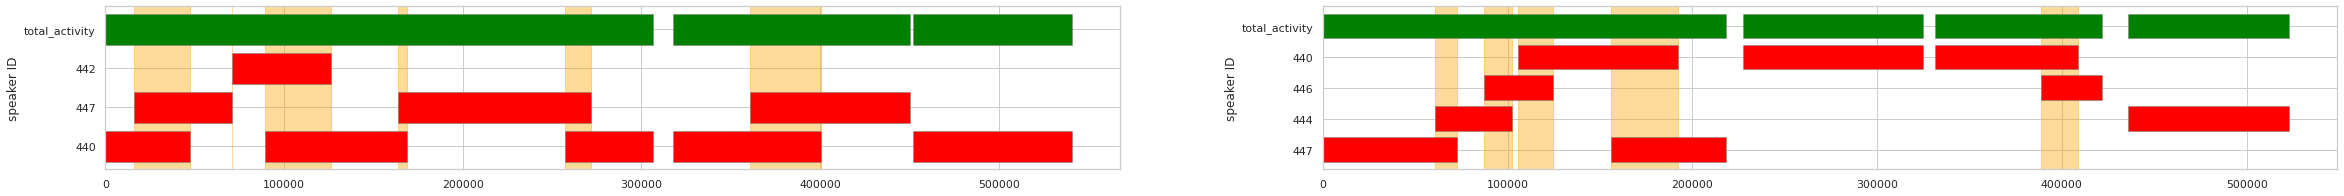

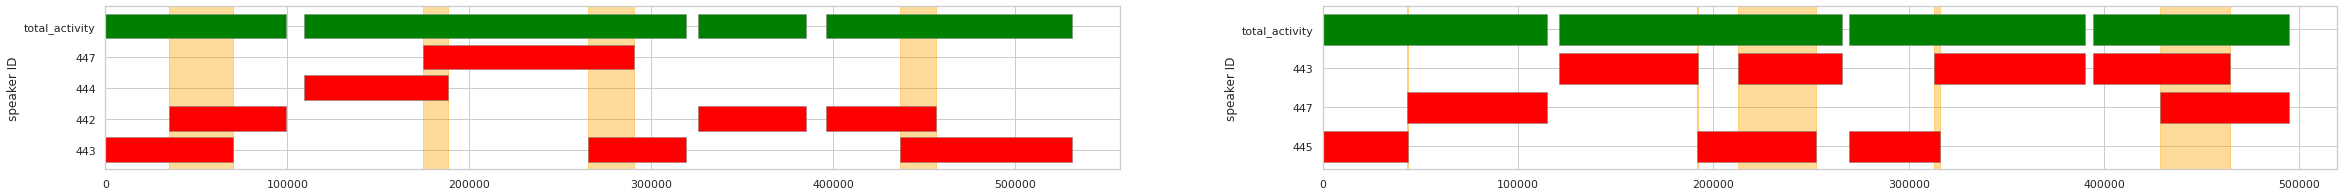

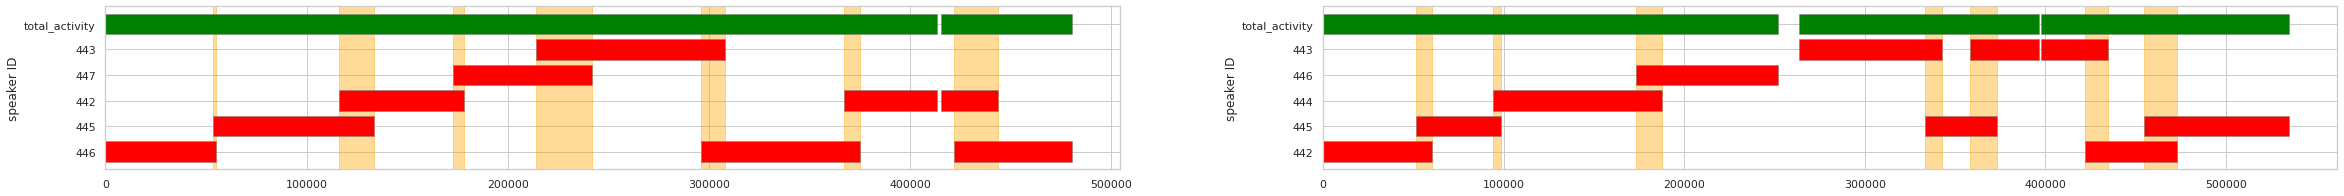

In [19]:
plot_meetings(ds, columns=2, figure_width=20, number=6)

### With reverberation

In [21]:
# With rir, use the same base function as for SMS-WSJ, i.e., we have the same initial examples as SMS-WSJ
import functools
ds = g.get_composition_dataset(input_dataset=input_ds, num_speakers=[3, 4])
ds = ds.map(g.UniformLogWeightSampler(max_weight=5))
ds = ds.map(g.RIRSampler.from_scenarios_json('/net/db/sms_wsj/rirs/scenarios.json', 'test_eval92'))
ds = ds.map(g.MeetingSampler(duration=60*8000)(input_ds))
ds[0]

{'audio_path': {'original_source': ['/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040d.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040i.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/442/442c0408.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c0408.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040n.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040k.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c040c.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/447/447c040r.wav',
   '/net/fastdb/wsj_8k/11-14.1/wsj0/si_et_20/440/440c0402.wav'],
  'rir': [PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_0.wav'),
   PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_1.wav'),
   PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_2.wav'),
   PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_0.wav'),
   PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_1.wav'),
   PosixPath('/net/db/sms_wsj/rirs/test_eval92/0/h_0.wav'),
   PosixPath('/net/db/s

### Based on LibriSpeech

In [22]:
# Librispeech
from padercontrib.database.librispeech import LibriSpeech

db = LibriSpeech()

# Map scenario: scenario is composed of speaker-ID and chapter-ID because the environment changes heavily between chapters
def format_fn(example):
    example['scenario'] = example['speaker_id'] + '_' + example['chapter_id']
    return example

librispeech_input_ds = db.get_dataset('test_clean').map(format_fn)

In [23]:
librispeech_input_ds[0]

{'audio_path': {'observation': '/net/db/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac'},
 'chapter_id': '134686',
 'gender': 'male',
 'kaldi_transcription': 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 'num_samples': 166960,
 'speaker_id': '1089',
 'example_id': '1089-134686-0000',
 'dataset': 'test_clean',
 'scenario': '1089_134686'}

In [26]:
# This code is exactly the same as for WSJ, except for the input dataset and some config
ds = g.get_composition_dataset(input_dataset=librispeech_input_ds, num_speakers=(5, 8))
ds = ds.map(g.UniformLogWeightSampler())
ds = ds.map(g.MeetingSampler(120*16000)(librispeech_input_ds))
ds[0]

{'audio_path': {'original_source': ['/net/db/LibriSpeech/test-clean/260/123440/260-123440-0005.flac',
   '/net/db/LibriSpeech/test-clean/1995/1837/1995-1837-0029.flac',
   '/net/db/LibriSpeech/test-clean/5105/28241/5105-28241-0016.flac',
   '/net/db/LibriSpeech/test-clean/3729/6852/3729-6852-0027.flac',
   '/net/db/LibriSpeech/test-clean/1188/133604/1188-133604-0008.flac',
   '/net/db/LibriSpeech/test-clean/5105/28241/5105-28241-0008.flac',
   '/net/db/LibriSpeech/test-clean/260/123440/260-123440-0002.flac',
   '/net/db/LibriSpeech/test-clean/1995/1837/1995-1837-0018.flac',
   '/net/db/LibriSpeech/test-clean/3729/6852/3729-6852-0044.flac',
   '/net/db/LibriSpeech/test-clean/3729/6852/3729-6852-0017.flac',
   '/net/db/LibriSpeech/test-clean/260/123440/260-123440-0007.flac',
   '/net/db/LibriSpeech/test-clean/260/123440/260-123440-0000.flac',
   '/net/db/LibriSpeech/test-clean/1995/1837/1995-1837-0024.flac',
   '/net/db/LibriSpeech/test-clean/5105/28241/5105-28241-0005.flac',
   '/net/db

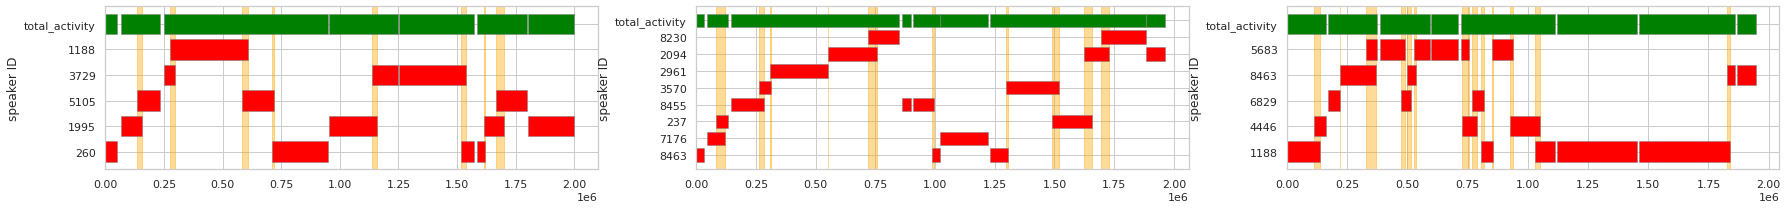

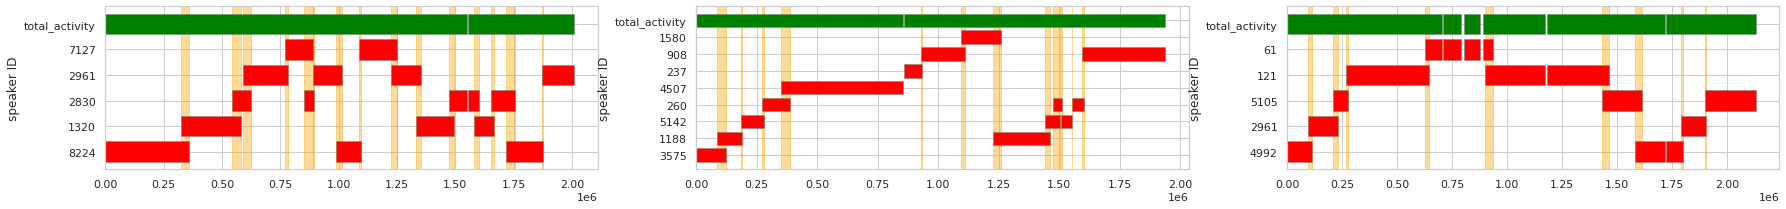

In [27]:
plot_meetings(ds)

## Class-based interface idea

In [28]:
db = g.wsj_full_overlap.WSJ8_kHz_FullOverlap()

In [29]:
db.dataset_names

('cv_dev93',
 'cv_dev93_5k',
 'test_eval92',
 'test_eval92_5k',
 'test_eval93',
 'test_eval93_5k',
 'train_si284',
 'train_si84')

In [30]:
db.get_dataset('cv_dev93')[0]

{'audio_path': {'original_source': ['/net/fastdb/wsj_8k/13-16.1/wsj1/si_dt_20/4k4/4k4c030k.wav',
   '/net/fastdb/wsj_8k/13-16.1/wsj1/si_dt_20/4k1/4k1c030f.wav']},
 'example_id': '0_4k4c030k_4k1c030f',
 'gender': ['female', 'male'],
 'kaldi_transcription': ['NORTHWEST PREVIOUSLY ORDERED THIRTY BOEING SEVEN FIFTY SEVENS OF WHICH TWENTY EIGHT HAVE BEEN DELIVERED TO DATE',
  'SEAFOOD IS DIRECTLY RELATED TO HEALTH HE SAID'],
 'num_samples': {'original_source': [68060, 31394], 'observation': 68060},
 'speaker_id': ['4k4', '4k1'],
 'transcription': ['NORTHWEST PREVIOUSLY ORDERED THIRTY BOEING SEVEN FIFTY SEVENS OF WHICH TWENTY EIGHT HAVE BEEN DELIVERED TO DATE',
  'SEAFOOD IS DIRECTLY RELATED TO HEALTH HE SAID'],
 'dataset': 'cv_dev93',
 'scenario': ['4k4', '4k1'],
 'num_speakers': 2,
 'source_dataset': ['cv_dev93', 'cv_dev93'],
 'source_id': ['4k4c030k', '4k1c030f'],
 'log_weights': [1.3315184163543288, -1.3315184163543292],
 'offset': {'original_source': [0, 3621]}}

## Generate JSON

In [31]:
from tqdm.notebook import tqdm
database_dict = {'datasets': {dataset_name: dict(tqdm(db.get_dataset(dataset_name).items(), desc=dataset_name)) for dataset_name in db.dataset_names}}
pb.io.dump(database_dict, 'wsj_full_overlap.json')